# En este cuaderno se pretende aplicar la clasifiación a las escenas generadas por LLMs

## Librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import fasttext
import pickle
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

## Datos

In [2]:
df = pd.read_csv('The Saimpsons Archive/Respuestas/respuestas_LLMs.csv')
df.sample()

,fine_tuned,input_character_raw,input_location_raw,raw_text,id,location_output
4,True,"['Homer Simpson', 'Grampa Simpson', 'Helen Lov...",Springfield Retirement Castle,(Springfield Retirement Castle: EXT. RETIREMEN...,ft1_char1_loc1_0,springfield retirement castle


In [3]:
df = df[['id', 'fine_tuned', 'location_output','raw_text']]
df.sample()

,id,fine_tuned,location_output,raw_text
17,ft1_char0_loc1_2,True,springfield elementary school,(Springfield Elementary School: ext. springfie...


In [4]:
df_loc = pd.read_csv('The Saimpsons Archive/OG/simpsons_locations.csv')
df_loc = df_loc.rename(columns={'id':'location_id'})
df_loc.sample()

,location_id,name,normalized_name
2641,2641,QUEEN'S BEDCHAMBER,queen bedchamber


In [5]:
# df.shape, df.isna().sum()

# Tratamiento de datos del Dataframe

## Añadiendo el location_id

In [6]:
df = pd.merge(left=df, right=df_loc[['normalized_name','location_id']], left_on='location_output', right_on='normalized_name', how='left')
df.head()

,id,fine_tuned,location_output,raw_text,normalized_name,location_id
0,ft1_char0_loc0_0,True,simpson house,(The Simpsons: ext. simpsons' house - morning ...,simpson house,910.0
1,ft1_char1_loc0_0,True,NaN,"(Homer Simpson: AD LIB OF ""YEAH"" WITH A MOUTHF...",NaN,NaN
2,ft1_char1_loc0_1,True,NaN,"Bart Simpson: (SINCERE) I'm glad you're back, ...",NaN,NaN
3,ft1_char1_loc0_2,True,burns estate,(ANOTHER PART OF THE ESTATE - CONTINUOUS)\nC. ...,burns estate,2987.0
4,ft1_char1_loc1_0,True,springfield retirement castle,(Springfield Retirement Castle: EXT. RETIREMEN...,springfield retirement castle,79.0


In [7]:
print(df.isna().sum(), '\n')
df['location_id'] = df['location_id'].fillna(0)
print(df.isna().sum())

id                 0
fine_tuned         0
location_output    2
raw_text           0
normalized_name    2
location_id        2
dtype: int64 

id                 0
fine_tuned         0
location_output    2
raw_text           0
normalized_name    2
location_id        0
dtype: int64


## Separando cada linea en su propia fila del dataframe

In [8]:
df['raw_text_split'] = df['raw_text'].str.split('\n')
df['lineas'] = df['raw_text_split'].apply(len)
df

,id,fine_tuned,location_output,raw_text,normalized_name,location_id,raw_text_split,lineas
0,ft1_char0_loc0_0,True,simpson house,(The Simpsons: ext. simpsons' house - morning ...,simpson house,910.0,[(The Simpsons: ext. simpsons' house - morning...,8
1,ft1_char1_loc0_0,True,NaN,"(Homer Simpson: AD LIB OF ""YEAH"" WITH A MOUTHF...",NaN,0.0,"[(Homer Simpson: AD LIB OF ""YEAH"" WITH A MOUTH...",3
2,ft1_char1_loc0_1,True,NaN,"Bart Simpson: (SINCERE) I'm glad you're back, ...",NaN,0.0,"[Bart Simpson: (SINCERE) I'm glad you're back,...",14
3,ft1_char1_loc0_2,True,burns estate,(ANOTHER PART OF THE ESTATE - CONTINUOUS)\nC. ...,burns estate,2987.0,"[(ANOTHER PART OF THE ESTATE - CONTINUOUS), C....",6
4,ft1_char1_loc1_0,True,springfield retirement castle,(Springfield Retirement Castle: EXT. RETIREMEN...,springfield retirement castle,79.0,[(Springfield Retirement Castle: EXT. RETIREME...,12
5,ft1_char1_loc1_1,True,springfield elementary school,(Springfield Elementary School: int. Springfie...,springfield elementary school,3.0,[(Springfield Elementary School: int. Springfi...,15
6,ft1_char1_loc1_2,True,sex shop,(SEX SHOP: Int. sex shop - continuous)\nHelen ...,sex shop,4205.0,"[(SEX SHOP: Int. sex shop - continuous), Helen...",33
7,ft1_char1_loc1_3,True,springfield swamp,(SPRINGFIELD SWAMP: Ext. springfield swamp - c...,springfield swamp,4209.0,[(SPRINGFIELD SWAMP: Ext. springfield swamp - ...,7
8,ft1_char1_loc1_4,True,simpson home,(Simpson Home: INT. simpson house - FAMILY ROO...,simpson home,5.0,[(Simpson Home: INT. simpson house - FAMILY RO...,22
9,ft0_char0_loc0_0,False,simpson living room,(Interior: Simpson living room. Marge is sitti...,simpson living room,25.0,[(Interior: Simpson living room. Marge is sitt...,26


In [9]:
df['raw_text_split'][0]

["(The Simpsons: ext. simpsons' house - morning - establishing)",
 "(The Simpsons: INT. SIMPSONS' HOUSE - HALLWAY - CONTINUOUS)",
 "Homer Simpson: Marge, this morning I saw a child who was kind of sickly looking, and I'm worried that it might be Bart.",
 "(The Simpsons: INT. SIMPSONS' HOUSE - kitchen - day)",
 "Homer Simpson: Marge, the kids are finally asleep. I told 'em a story about a horse and a monkey and they went right out.",
 "Homer Simpson: (FEELING HIS PANTS) Oh, no. (STANDS UP) I'm wearing kid pants.",
 "(The Simpsons: INT. SIMPSONS' HOUSE - KITCHEN - DAY)",
 "Homer Simpson: Marge, you've gotta help me. They're just like the monsters under my bed when I was little. Except they're real."]

In [10]:
df = df.explode('raw_text_split')
df

,id,fine_tuned,location_output,raw_text,normalized_name,location_id,raw_text_split,lineas
0,ft1_char0_loc0_0,True,simpson house,(The Simpsons: ext. simpsons' house - morning ...,simpson house,910.0,(The Simpsons: ext. simpsons' house - morning ...,8
0,ft1_char0_loc0_0,True,simpson house,(The Simpsons: ext. simpsons' house - morning ...,simpson house,910.0,(The Simpsons: INT. SIMPSONS' HOUSE - HALLWAY ...,8
0,ft1_char0_loc0_0,True,simpson house,(The Simpsons: ext. simpsons' house - morning ...,simpson house,910.0,"Homer Simpson: Marge, this morning I saw a chi...",8
0,ft1_char0_loc0_0,True,simpson house,(The Simpsons: ext. simpsons' house - morning ...,simpson house,910.0,(The Simpsons: INT. SIMPSONS' HOUSE - kitchen ...,8
0,ft1_char0_loc0_0,True,simpson house,(The Simpsons: ext. simpsons' house - morning ...,simpson house,910.0,"Homer Simpson: Marge, the kids are finally asl...",8
...,...,...,...,...,...,...,...,...
32,ft0_char1_loc1_2,False,kwik-e-mart parking lot,(Scene: Kwik-E-Mart Parking Lot. Homer is stan...,kwik-e-mart parking lot,163.0,"Homer Simpson: Oh, hey Chief! Just a little tr...",17
32,ft0_char1_loc1_2,False,kwik-e-mart parking lot,(Scene: Kwik-E-Mart Parking Lot. Homer is stan...,kwik-e-mart parking lot,163.0,"Chief Wiggum: Well, as long as there's no ille...",17
32,ft0_char1_loc1_2,False,kwik-e-mart parking lot,(Scene: Kwik-E-Mart Parking Lot. Homer is stan...,kwik-e-mart parking lot,163.0,(Homer nods eagerly as Chief Wiggum walks away...,17
32,ft0_char1_loc1_2,False,kwik-e-mart parking lot,(Scene: Kwik-E-Mart Parking Lot. Homer is stan...,kwik-e-mart parking lot,163.0,"Apu Nahasapeemapetilon: Ah, the sweet taste of...",17


In [11]:
df['raw_text'] = df['raw_text_split']
df = df[['id', 'fine_tuned', 'location_id', 'raw_text']]
df

,id,fine_tuned,location_id,raw_text
0,ft1_char0_loc0_0,True,910.0,(The Simpsons: ext. simpsons' house - morning ...
0,ft1_char0_loc0_0,True,910.0,(The Simpsons: INT. SIMPSONS' HOUSE - HALLWAY ...
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, this morning I saw a chi..."
0,ft1_char0_loc0_0,True,910.0,(The Simpsons: INT. SIMPSONS' HOUSE - kitchen ...
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, the kids are finally asl..."
...,...,...,...,...
32,ft0_char1_loc1_2,False,163.0,"Homer Simpson: Oh, hey Chief! Just a little tr..."
32,ft0_char1_loc1_2,False,163.0,"Chief Wiggum: Well, as long as there's no ille..."
32,ft0_char1_loc1_2,False,163.0,(Homer nods eagerly as Chief Wiggum walks away...
32,ft0_char1_loc1_2,False,163.0,"Apu Nahasapeemapetilon: Ah, the sweet taste of..."


## Separando los personajes que hablan y sus diálogos y poniendolos en su propia columna.

In [12]:
df['raw_character'] = df['raw_text'].str.split(':').str[0]
df.loc[df['raw_character'].str.startswith('('), 'raw_character'] = np.nan

df['spoken_words'] = df['raw_text'].str.split(':').str[1]
df['spoken_words'] = np.where(df['raw_character'].isna(), np.nan, df['spoken_words'])

df['speaking_line'] = df['raw_character'].notna()

df = df[['id', 'fine_tuned', 'location_id', 'raw_text', 'speaking_line', 'raw_character', 'spoken_words']]
# df.to_csv('The Saimpsons Archive/Respuestas/respuestas_interacciones_LLMs.csv', index=False)
df

,id,fine_tuned,location_id,raw_text,speaking_line,raw_character,spoken_words
0,ft1_char0_loc0_0,True,910.0,(The Simpsons: ext. simpsons' house - morning ...,False,NaN,NaN
0,ft1_char0_loc0_0,True,910.0,(The Simpsons: INT. SIMPSONS' HOUSE - HALLWAY ...,False,NaN,NaN
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, this morning I saw a chi...",True,Homer Simpson,"Marge, this morning I saw a child who was kin..."
0,ft1_char0_loc0_0,True,910.0,(The Simpsons: INT. SIMPSONS' HOUSE - kitchen ...,False,NaN,NaN
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, the kids are finally asl...",True,Homer Simpson,"Marge, the kids are finally asleep. I told 'e..."
...,...,...,...,...,...,...,...
32,ft0_char1_loc1_2,False,163.0,"Homer Simpson: Oh, hey Chief! Just a little tr...",True,Homer Simpson,"Oh, hey Chief! Just a little trunk trouble, b..."
32,ft0_char1_loc1_2,False,163.0,"Chief Wiggum: Well, as long as there's no ille...",True,Chief Wiggum,"Well, as long as there's no illegal donut smu..."
32,ft0_char1_loc1_2,False,163.0,(Homer nods eagerly as Chief Wiggum walks away...,False,NaN,NaN
32,ft0_char1_loc1_2,False,163.0,"Apu Nahasapeemapetilon: Ah, the sweet taste of...",True,Apu Nahasapeemapetilon,"Ah, the sweet taste of victory... and donuts...."


# Filtrados

## Filtrado de speaking lines

In [13]:
df = df[df['speaking_line']==True]
df

,id,fine_tuned,location_id,raw_text,speaking_line,raw_character,spoken_words
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, this morning I saw a chi...",True,Homer Simpson,"Marge, this morning I saw a child who was kin..."
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, the kids are finally asl...",True,Homer Simpson,"Marge, the kids are finally asleep. I told 'e..."
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: (FEELING HIS PANTS) Oh, no. (ST...",True,Homer Simpson,"(FEELING HIS PANTS) Oh, no. (STANDS UP) I'm w..."
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, you've gotta help me. Th...",True,Homer Simpson,"Marge, you've gotta help me. They're just lik..."
1,ft1_char1_loc0_0,True,0.0,Bart Simpson: Is there no place on this Earth ...,True,Bart Simpson,Is there no place on this Earth for a kid who...
...,...,...,...,...,...,...,...
32,ft0_char1_loc1_2,False,163.0,"Homer Simpson: My precious donuts! Apu, you're...",True,Homer Simpson,"My precious donuts! Apu, you're a genius!"
32,ft0_char1_loc1_2,False,163.0,Chief Wiggum: What's going on here? I got a re...,True,Chief Wiggum,What's going on here? I got a report of a don...
32,ft0_char1_loc1_2,False,163.0,"Homer Simpson: Oh, hey Chief! Just a little tr...",True,Homer Simpson,"Oh, hey Chief! Just a little trunk trouble, b..."
32,ft0_char1_loc1_2,False,163.0,"Chief Wiggum: Well, as long as there's no ille...",True,Chief Wiggum,"Well, as long as there's no illegal donut smu..."


## Crear columna char_simplified

In [14]:
def what_char(text):
    words = text.lower()
    words = words.split()

    if 'homer' in words:
        return 'Homer Simpson'
    elif 'marge' in words:
        return 'Marge Simpson'
    elif 'bart' in words:
        return 'Bart Simpson'
    elif 'lisa' in words:
        return 'Lisa Simpson'
    else:
        return 'Others'

In [15]:
df['char_simplified'] = df['raw_character'].apply(lambda x: what_char(x))
df

,id,fine_tuned,location_id,raw_text,speaking_line,raw_character,spoken_words,char_simplified
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, this morning I saw a chi...",True,Homer Simpson,"Marge, this morning I saw a child who was kin...",Homer Simpson
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, the kids are finally asl...",True,Homer Simpson,"Marge, the kids are finally asleep. I told 'e...",Homer Simpson
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: (FEELING HIS PANTS) Oh, no. (ST...",True,Homer Simpson,"(FEELING HIS PANTS) Oh, no. (STANDS UP) I'm w...",Homer Simpson
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, you've gotta help me. Th...",True,Homer Simpson,"Marge, you've gotta help me. They're just lik...",Homer Simpson
1,ft1_char1_loc0_0,True,0.0,Bart Simpson: Is there no place on this Earth ...,True,Bart Simpson,Is there no place on this Earth for a kid who...,Bart Simpson
...,...,...,...,...,...,...,...,...
32,ft0_char1_loc1_2,False,163.0,"Homer Simpson: My precious donuts! Apu, you're...",True,Homer Simpson,"My precious donuts! Apu, you're a genius!",Homer Simpson
32,ft0_char1_loc1_2,False,163.0,Chief Wiggum: What's going on here? I got a re...,True,Chief Wiggum,What's going on here? I got a report of a don...,Others
32,ft0_char1_loc1_2,False,163.0,"Homer Simpson: Oh, hey Chief! Just a little tr...",True,Homer Simpson,"Oh, hey Chief! Just a little trunk trouble, b...",Homer Simpson
32,ft0_char1_loc1_2,False,163.0,"Chief Wiggum: Well, as long as there's no ille...",True,Chief Wiggum,"Well, as long as there's no illegal donut smu...",Others


## Filtrado de número de palabras de intervención (mínimo 5)

In [16]:
df.isna().sum()

id                  0
fine_tuned          0
location_id         0
raw_text            0
speaking_line       0
raw_character       0
spoken_words       13
char_simplified     0
dtype: int64

In [17]:
df = df.dropna(subset=['spoken_words'])

In [18]:
def count_words(text):
    return len(text.split())

df['spoken_words_count'] = df['spoken_words'].apply(lambda x: count_words(x))
df

,id,fine_tuned,location_id,raw_text,speaking_line,raw_character,spoken_words,char_simplified,spoken_words_count
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, this morning I saw a chi...",True,Homer Simpson,"Marge, this morning I saw a child who was kin...",Homer Simpson,21
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, the kids are finally asl...",True,Homer Simpson,"Marge, the kids are finally asleep. I told 'e...",Homer Simpson,22
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: (FEELING HIS PANTS) Oh, no. (ST...",True,Homer Simpson,"(FEELING HIS PANTS) Oh, no. (STANDS UP) I'm w...",Homer Simpson,11
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, you've gotta help me. Th...",True,Homer Simpson,"Marge, you've gotta help me. They're just lik...",Homer Simpson,20
1,ft1_char1_loc0_0,True,0.0,Bart Simpson: Is there no place on this Earth ...,True,Bart Simpson,Is there no place on this Earth for a kid who...,Bart Simpson,14
...,...,...,...,...,...,...,...,...,...
32,ft0_char1_loc1_2,False,163.0,"Homer Simpson: My precious donuts! Apu, you're...",True,Homer Simpson,"My precious donuts! Apu, you're a genius!",Homer Simpson,7
32,ft0_char1_loc1_2,False,163.0,Chief Wiggum: What's going on here? I got a re...,True,Chief Wiggum,What's going on here? I got a report of a don...,Others,12
32,ft0_char1_loc1_2,False,163.0,"Homer Simpson: Oh, hey Chief! Just a little tr...",True,Homer Simpson,"Oh, hey Chief! Just a little trunk trouble, b...",Homer Simpson,16
32,ft0_char1_loc1_2,False,163.0,"Chief Wiggum: Well, as long as there's no ille...",True,Chief Wiggum,"Well, as long as there's no illegal donut smu...",Others,31


In [19]:
df = df.query('spoken_words_count >= 5')
df.shape

(372, 9)

In [20]:
df=df.reset_index()
df=df.drop('index', axis=1)
df

,id,fine_tuned,location_id,raw_text,speaking_line,raw_character,spoken_words,char_simplified,spoken_words_count
0,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, this morning I saw a chi...",True,Homer Simpson,"Marge, this morning I saw a child who was kin...",Homer Simpson,21
1,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, the kids are finally asl...",True,Homer Simpson,"Marge, the kids are finally asleep. I told 'e...",Homer Simpson,22
2,ft1_char0_loc0_0,True,910.0,"Homer Simpson: (FEELING HIS PANTS) Oh, no. (ST...",True,Homer Simpson,"(FEELING HIS PANTS) Oh, no. (STANDS UP) I'm w...",Homer Simpson,11
3,ft1_char0_loc0_0,True,910.0,"Homer Simpson: Marge, you've gotta help me. Th...",True,Homer Simpson,"Marge, you've gotta help me. They're just lik...",Homer Simpson,20
4,ft1_char1_loc0_0,True,0.0,Bart Simpson: Is there no place on this Earth ...,True,Bart Simpson,Is there no place on this Earth for a kid who...,Bart Simpson,14
...,...,...,...,...,...,...,...,...,...
367,ft0_char1_loc1_2,False,163.0,"Homer Simpson: My precious donuts! Apu, you're...",True,Homer Simpson,"My precious donuts! Apu, you're a genius!",Homer Simpson,7
368,ft0_char1_loc1_2,False,163.0,Chief Wiggum: What's going on here? I got a re...,True,Chief Wiggum,What's going on here? I got a report of a don...,Others,12
369,ft0_char1_loc1_2,False,163.0,"Homer Simpson: Oh, hey Chief! Just a little tr...",True,Homer Simpson,"Oh, hey Chief! Just a little trunk trouble, b...",Homer Simpson,16
370,ft0_char1_loc1_2,False,163.0,"Chief Wiggum: Well, as long as there's no ille...",True,Chief Wiggum,"Well, as long as there's no illegal donut smu...",Others,31


# Word embedding

In [21]:
text_column = df['spoken_words']
#text_column.to_csv('The Saimpsons Archive/in_use/text_data_train_fasttext_spoken_words.txt', index=False, header=False, sep='\n')

# Entrenando al fasttext embedding_model a usar
embedding_model = fasttext.train_supervised(input="The Saimpsons Archive/in_use/text_data_train_fasttext.txt", lr=0.1, epoch=25, wordNgrams=2)

# Function to obtain FastText embeddings for a single text
def get_fasttext_embedding(text):
    text = text.replace('\n', '')
    return embedding_model.get_sentence_vector(text)

# Apply the function to each text in the DataFrame column
embeddings = text_column.apply(get_fasttext_embedding)

# Convert embeddings to DataFrame
embedding_df = pd.DataFrame(embeddings.tolist(), columns=[f'embedding_{i}' for i in range(embeddings.iloc[0].shape[0])])

# Concatenate the embedding DataFrame with the original DataFrame
result_df = pd.concat([df[['fine_tuned', 'char_simplified', 'location_id']], embedding_df], axis=1)

Read 1M words
Number of words:  137245
Number of labels: 0
Progress: 100.0% words/sec/thread: 12728778 lr:  0.000000 avg.loss:       nan ETA:   0h 0m 0s


In [22]:
df.shape, embedding_df.shape, result_df.shape

((372, 9), (372, 100), (372, 103))

In [23]:
result_df.sample()

,fine_tuned,char_simplified,location_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,...,embedding_90,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99
104,False,Marge Simpson,25.0,0.000764,-0.000965,0.001406,-0.000022,-0.002917,0.000828,0.000692,...,0.001357,-0.000457,-0.000053,-0.001495,0.000322,-0.000033,-0.000935,0.002052,-0.003001,-0.002151


# Importando modelos

In [24]:
# PCA
with open('Modelos/Clasificación/pca.pkl', 'rb') as f:
    pca = pickle.load(f)

# Standard Scaler
with open('Modelos/Clasificación/standard_scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

# Random Forest Classifier
with open('Modelos/Clasificación/random_forest.pkl', 'rb') as f:
    modelo = pickle.load(f)

# Clasificación

In [25]:
# Dividir el DataFrame en características (X) y etiquetas (y)
X = result_df.drop(['fine_tuned', 'char_simplified'], axis=1) 
y_real = result_df['char_simplified']

## Aplicando PCA
X_pca = pca.transform(X)

# Escalar características para normalizarlas
X_scaled = scaler.transform(X_pca)

# Predicciones
y_pred = modelo.predict(X_scaled)

# Calcular la precisión del model_rfco
accuracy = accuracy_score(y_real, y_pred)
print("Accuracy:", accuracy)

# Mostrar el reporte de clasificación
print("\nClassification Report:")
print(classification_report(y_real, y_pred))

Accuracy: 0.24193548387096775

Classification Report:
               precision    recall  f1-score   support

 Bart Simpson       0.00      0.00      0.00        47
Homer Simpson       0.17      0.75      0.28        68
 Lisa Simpson       0.00      0.00      0.00        38
Marge Simpson       0.00      0.00      0.00        37
       Others       0.54      0.21      0.31       182

     accuracy                           0.24       372
    macro avg       0.14      0.19      0.12       372
 weighted avg       0.30      0.24      0.20       372



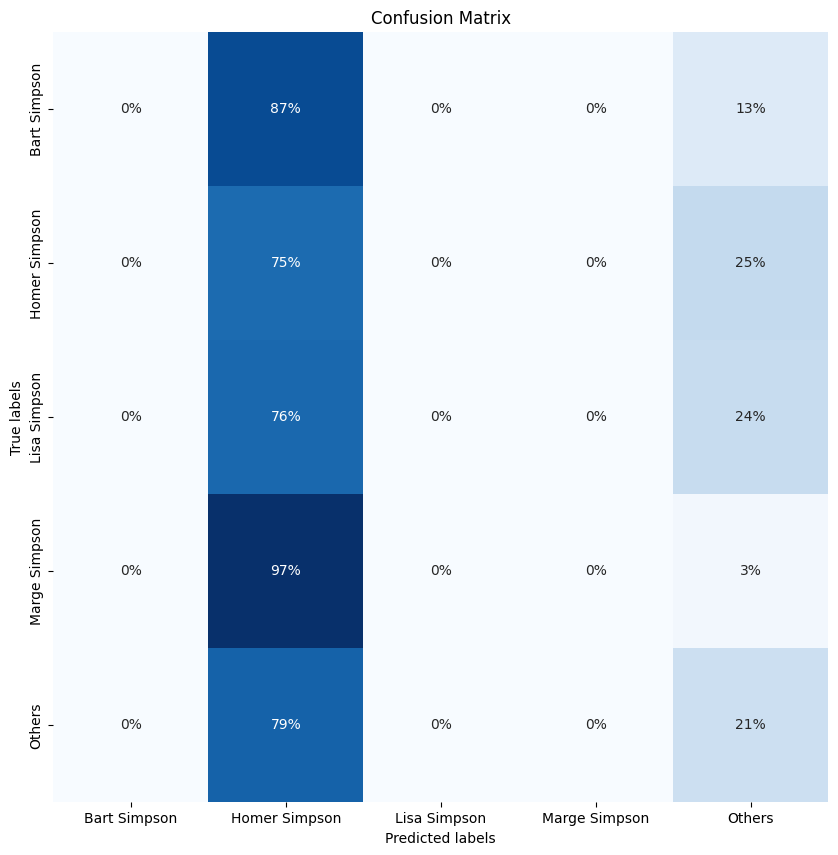

In [26]:
class_labels = np.unique(y_real)
conf_matrix=confusion_matrix(y_real, y_pred, normalize='true')

plt.figure(figsize=(10,10))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='.0%', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [27]:
result_df['y_pred'] = y_pred
result_df.sample()

,fine_tuned,char_simplified,location_id,embedding_0,embedding_1,embedding_2,embedding_3,embedding_4,embedding_5,embedding_6,...,embedding_91,embedding_92,embedding_93,embedding_94,embedding_95,embedding_96,embedding_97,embedding_98,embedding_99,y_pred
256,True,Lisa Simpson,1.0,-0.000672,-0.000254,-0.000726,-0.001731,-0.001702,0.003208,0.000452,...,-0.002873,0.000432,-0.001553,0.000128,0.001555,-0.001763,0.000991,-0.00094,-0.000359,Homer Simpson


In [28]:
y_pred_ft0 = result_df[result_df['fine_tuned']==False]['y_pred']
y_pred_ft1 = result_df[result_df['fine_tuned']==True]['y_pred']

y_real_ft0 = result_df[result_df['fine_tuned']==False]['char_simplified']
y_real_ft1 = result_df[result_df['fine_tuned']==True]['char_simplified']

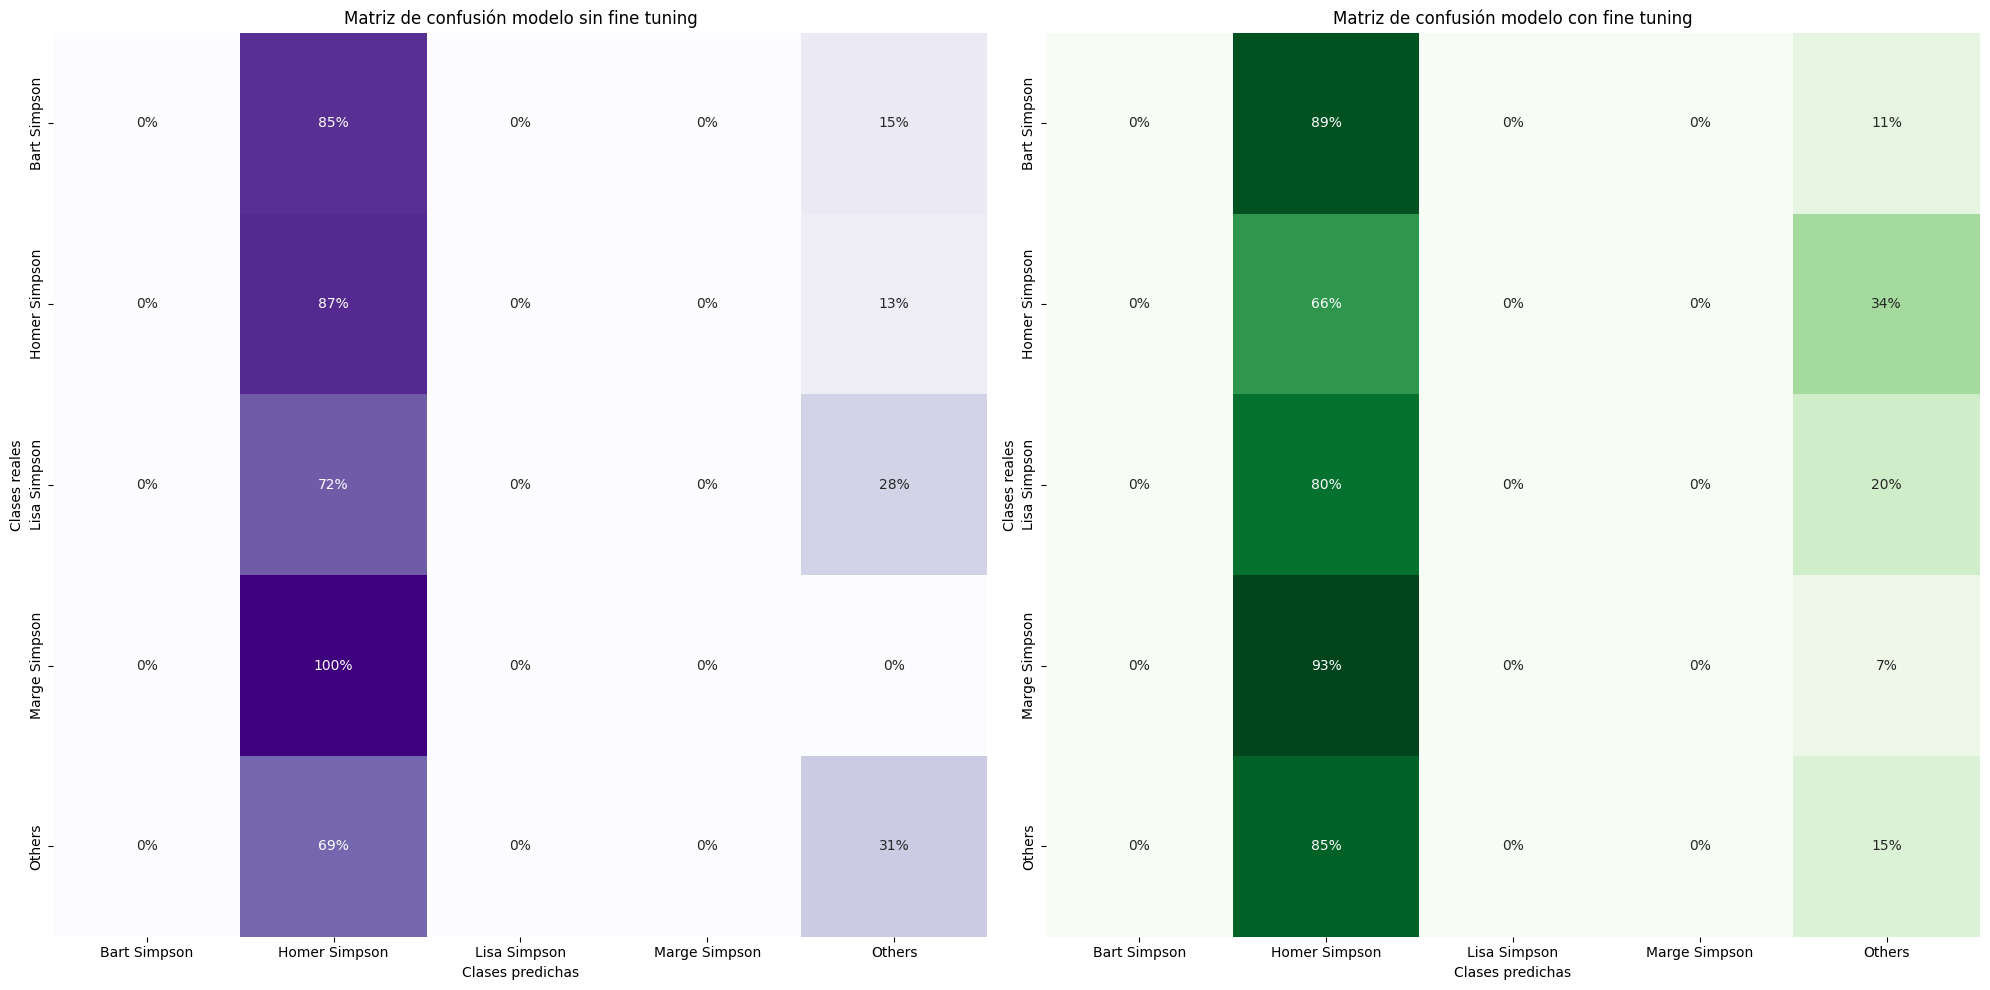

In [29]:
class_labels_ft0 = np.unique(y_real_ft0)
conf_matrix_ft0 = confusion_matrix(y_real_ft0, y_pred_ft0, normalize='true')

class_labels_ft1 = np.unique(y_real_ft1)
conf_matrix_ft1 = confusion_matrix(y_real_ft1, y_pred_ft1, normalize='true')

fig, axes = plt.subplots(1, 2, figsize=(20, 10))  # Crear un subplot de 1 fila y 2 columnas

# Primera matriz de confusión
sns.heatmap(conf_matrix_ft0, annot=True, cmap='Purples', fmt='.0%', cbar=False, 
            xticklabels=class_labels_ft0, yticklabels=class_labels_ft0, ax=axes[0])
axes[0].set_xlabel('Clases predichas')
axes[0].set_ylabel('Clases reales')
axes[0].set_title('Matriz de confusión modelo sin fine tuning')

# Segunda matriz de confusión
sns.heatmap(conf_matrix_ft1, annot=True, cmap='Greens', fmt='.0%', cbar=False, 
            xticklabels=class_labels_ft1, yticklabels=class_labels_ft1, ax=axes[1])
axes[1].set_xlabel('Clases predichas')
axes[1].set_ylabel('Clases reales')
axes[1].set_title('Matriz de confusión modelo con fine tuning')

plt.tight_layout()  # Ajustar el layout para que no se solapen las etiquetas
plt.show()
